In [2]:
import re
import sys
import os
import numpy as np
import scipy.signal as signal
import pandas as pd
from scipy.ndimage import uniform_filter
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy import cluster
from scipy.cluster.hierarchy import dendrogram
import uuid

from collections import defaultdict

import PCprophet.io_ as io
import PCprophet.stats_ as st




In [3]:
# generate empty dict
def makehash(w=dict):
    """autovivification like hash in perl
    http://stackoverflow.com/questions/651794/whats-the-best-way-to-initialize-a-dict-of-dicts-in-python
    use call it on hash like h = makehash()
    then directly
    h[1][2]= 3
    useful ONLY for a 2 level hash
    """
    # return defaultdict(makehash)
    return defaultdict(w)

# convert txt to dict
def read_txt(path, first_col="GN"):
    """
    read a tab delimited file giving a path and the first column name
    return a hash of hashes prot => sample => val
    """
    header = []
    HoA = makehash()
    temp = {}
    for line in open(path, "r"):
        line = line.rstrip("\n")
        if line.startswith(str(first_col) + "\t"):
            header = re.split(r"\t+", line)
        else:
            things = re.split(r"\t+", line)
            temp = dict(zip(header, things))
        if temp:
            HoA[temp.get("GN")] = []
            for key in header:
                try:
                    HoA[temp.get("GN")].append(float(temp[key]))
                except ValueError as v:
                    continue
    gene_count = len(HoA)
    #function is called twice -> two prints
    print(f"Number of analyzed genes in {path}: {gene_count}")
    return HoA

# standardize and center methods
def center_arr_mtd(hoa, fr_nr="all", smooth=True, stretch=(True, 72), resc=True):
    norm = {}
    for k in hoa:
        key = hoa[k]
        if fr_nr != "all":
            key = key[0:(fr_nr)]
        # if less than 2 real values
        if len([x for x in key if x > 0]) < 2:
            continue
        if smooth:
            key = st.gauss_filter(key, sigma=1, order=0)
        key = st.impute_namean(key)
        if stretch[0]:
            # input original length wanted length
            key = st.resample(key, len(key), output_fr=stretch[1])
        if resc:
            key = st.resize(key)
        norm[str.upper(k)] = list(key)
    return norm

In [4]:
infile = "..\\test\\test_frac.txt"
dat_dict = read_txt(path=infile)

Number of analyzed genes in ..\test\test_frac.txt: 47


No handles with labels found to put in legend.


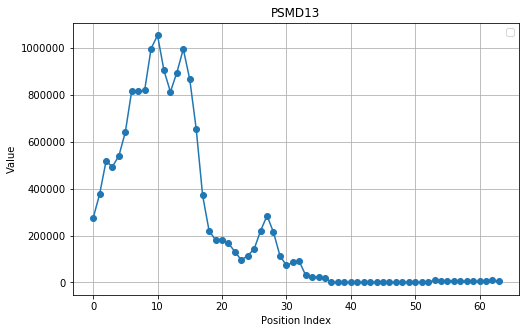

In [5]:
gene1 = next(iter(dat_dict))
dat_gene1 = dat_dict[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
dat_center = center_arr_mtd(dat_dict)

No handles with labels found to put in legend.


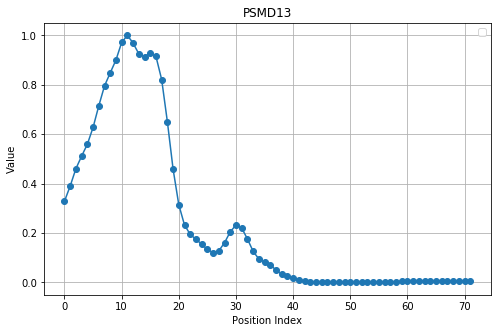

In [7]:
gene1 = next(iter(dat_center))
dat_gene1 = dat_center[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
def center_arr_hyp(hoa, fr_nr="all", norm=True, nat=True, stretch=(True, 72)):
    hypo = {}
    for k in hoa:
        key = hoa[k]
        if fr_nr != "all":
            key = key[0:(fr_nr)]
        if len([x for x in key if x > 0]) < 2:
            continue
        key = st.gauss_filter(key, sigma=1, order=0)
        key = st.impute_namean(key)
        if stretch[0]:
            # input original length wanted length
            key = st.resample(key, len(key), output_fr=stretch[1])
        key = st.resize(key)
        hypo[k] = list(key)
    return hypo

def decondense(df, ids):
    """
    decondense a linkage matrix into all flat clusters
    """
    clusters = {}
    rows = cluster.hierarchy.linkage(df)
    lab = dict(zip(range(len(ids) + 1), ids))
    for row in range(rows.shape[0]):
        cluster_n = row + len(ids)
        glob1, glob2 = rows[row, 0], rows[row, 1]
        current = []
        for glob in [glob1, glob2]:
            if glob > (len(ids) - 1):
                current += clusters[glob]
            else:
                current.append(lab[int(glob)])
        clusters[cluster_n] = current
    return clusters

def fill_zeroes(prot, pk, left_base, right_base):
    """
    check left and right side of peaks and zero if >
    """
    arr = prot.copy()
    arr[:left_base] = [0 for aa in arr[:left_base]]
    arr[right_base:] = [0 for aa in arr[right_base:]]
    right = zero_sequence(arr[pk : len(arr)])
    left = zero_sequence(arr[:pk][::-1])[::-1]
    return left + right


def zero_sequence(arr):
    idx = 0
    k = True
    while k:
        # if we are at end return array
        if idx == len(arr) - 1:
            return arr
        # if current value smaller than next (i.e increasing)
        elif arr[idx] < arr[(idx + 1)]:
            # slice until there
            tmp = arr[:idx]
            l = [0] * (len(arr) - len(tmp))
            return tmp + l
        idx += 1

def split_peaks(prot_arr, pr, skp=0):
    """
    split peaks in n samples giving skp fractions of window
    returns
    'right_bases': array([32]), 'left_bases': array([7])
    """
    peaks = list(st.peak_picking(prot_arr))
    left_bases = peaks[1]["left_bases"]
    right_bases = peaks[1]["right_bases"]
    fr_peak = peaks[0]
    ret = {}
    # if no return value or 1 peak
    if len(fr_peak) < 2:
        ret[pr] = prot_arr
        return ret
    for idx, pk in enumerate(fr_peak):
        if pk < 6 and pk > 69:
            continue
        nm = "_".join([pr, str(idx)])
        clean = fill_zeroes(prot_arr, pk, left_bases[idx], right_bases[idx])
        ret[nm] = clean
    return ret


def format_cluster(hoa, clust):
    out = {}
    lk = {k: ",".join(map(str, v)) for k, v in hoa.items()}
    for gn in clust.values():
        if len(gn) > 1 and len(gn) <= 100:
            gn = [x if x in lk else re.sub("_\d+$", "", x) for x in gn]
            out["#".join(gn)] = ["#".join([lk[x] for x in gn])]
    return out

def collapse_prot(infile, use):
    prot = read_txt(infile, "GN")
    prot = center_arr_hyp(prot, fr_nr=use, stretch=(True, 72))
    prot2 = {}
    for pr in prot:
        pks = split_peaks(prot[pr], pr)
        if pks:
            for k in pks:
                prot2[k] = pks[k]
    pr_df = io.create_df(prot2)
    z = decondense(pr_df, list(pr_df.index))
    hypothesis = format_cluster(prot, z)
    hypo_df = pd.DataFrame.from_dict(hypothesis).T
    hypo_df["ID"] = ["cmplx_" + str(uuid.uuid4()) for x in list(hypo_df.index)]
    return hypo_df, pr_df



In [9]:
use_fr = "all"

hypo, df_s = collapse_prot(infile=infile, use=use_fr)
hypo.reset_index(inplace=True)
hypo.columns = ["MB", "FT", "ID"]
hypo = hypo[["ID", "MB", "FT"]]

Number of analyzed genes in ..\test\test_frac.txt: 47


No handles with labels found to put in legend.


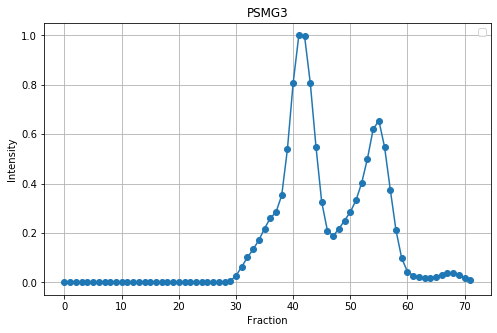

In [10]:
gene1 = 'PSMG3'
dat_gene1 = dat_center[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Fraction')
plt.ylabel('Intensity')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

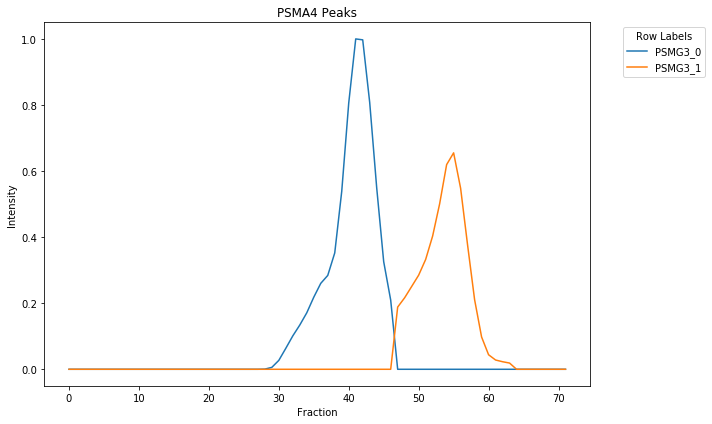

In [11]:
df_peaks_gene = df_s[df_s.index.str.contains(gene1)]

plt.figure(figsize=(10, 6))
for row_label, row_values in df_peaks_gene.iterrows():
    plt.plot(row_values, label=row_label)

# Customize the plot
plt.title('PSMA4 Peaks')
plt.xlabel('Fraction')
plt.ylabel('Intensity')
plt.legend(title='Row Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Probably a better idea to fit gaussians and define peaks like that?

In [12]:
cluster.hierarchy.linkage(df_s)

array([[4.20000000e+01, 6.70000000e+01, 1.19898232e-02, 2.00000000e+00],
       [8.00000000e+00, 5.20000000e+01, 1.24808406e-02, 2.00000000e+00],
       [5.60000000e+01, 7.10000000e+01, 2.09467292e-02, 2.00000000e+00],
       [6.90000000e+01, 9.90000000e+01, 2.34313969e-02, 3.00000000e+00],
       [7.30000000e+01, 1.00000000e+02, 2.43632268e-02, 3.00000000e+00],
       [5.40000000e+01, 6.40000000e+01, 2.58908229e-02, 2.00000000e+00],
       [1.03000000e+02, 1.04000000e+02, 2.62842405e-02, 5.00000000e+00],
       [1.01000000e+02, 1.05000000e+02, 2.93093575e-02, 7.00000000e+00],
       [3.70000000e+01, 7.20000000e+01, 2.97049742e-02, 2.00000000e+00],
       [3.60000000e+01, 1.06000000e+02, 3.23437807e-02, 8.00000000e+00],
       [8.50000000e+01, 1.08000000e+02, 3.30588290e-02, 9.00000000e+00],
       [9.00000000e+00, 5.70000000e+01, 4.34211061e-02, 2.00000000e+00],
       [1.00000000e+00, 8.90000000e+01, 4.51789544e-02, 2.00000000e+00],
       [7.40000000e+01, 1.10000000e+02, 4.67736351e

In [13]:
clusters = {}
ids = list(df_s.index)
rows = cluster.hierarchy.linkage(df_s)
lab = dict(zip(range(len(ids) + 1), ids))

dendrogram produces 99 leaves --> one per PEAK. not sure whether this behavior is wanted.

Also, if 

B C D is very rare and 

A B C is very abundant, the relative B C D peak in the B and C profiles will be very low and the A B C peak high while the B C D peak in in the D profile will be the only one and thus very high. So the peaks originating from the same complex will be very different in different relative intensity profiles - if this ends up leading to a dissimilar similarity metric, that would be a problem I think

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [75.0, 75.0, 85.0, 85.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [95.0, 95.0, 114.375, 114.375],
  [80.0, 80.0, 104.6875, 104.6875],
  [65.0, 65.0, 92.34375, 92.34375],
  [55.0, 55.0, 78.671875, 78.671875],
  [45.0, 45.0, 66.8359375, 66.8359375],
  [30.0, 30.0, 55.91796875, 55.91796875],
  [15.0, 15.0, 42.958984375, 42.958984375],
  [5.0, 5.0, 28.9794921875, 28.9794921875],
  [185.0, 185.0, 195.0, 195.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [235.0, 235.0, 245.0, 245.0],
  [265.0, 265.0, 275.0, 275.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [285.0, 285.0, 302.5, 302.5],
  [270.0, 270.0, 293.75, 293.75],
  [255.0, 255.0, 281.875, 281.875],
  [240.0, 240.0, 268.4375, 268.4375],
  [212.5, 212.5, 254.21875, 254.21875],
  [190.0, 190.0, 233.359375, 233.359375],
  [175.0, 175.0, 211.6796875, 211.6796875],


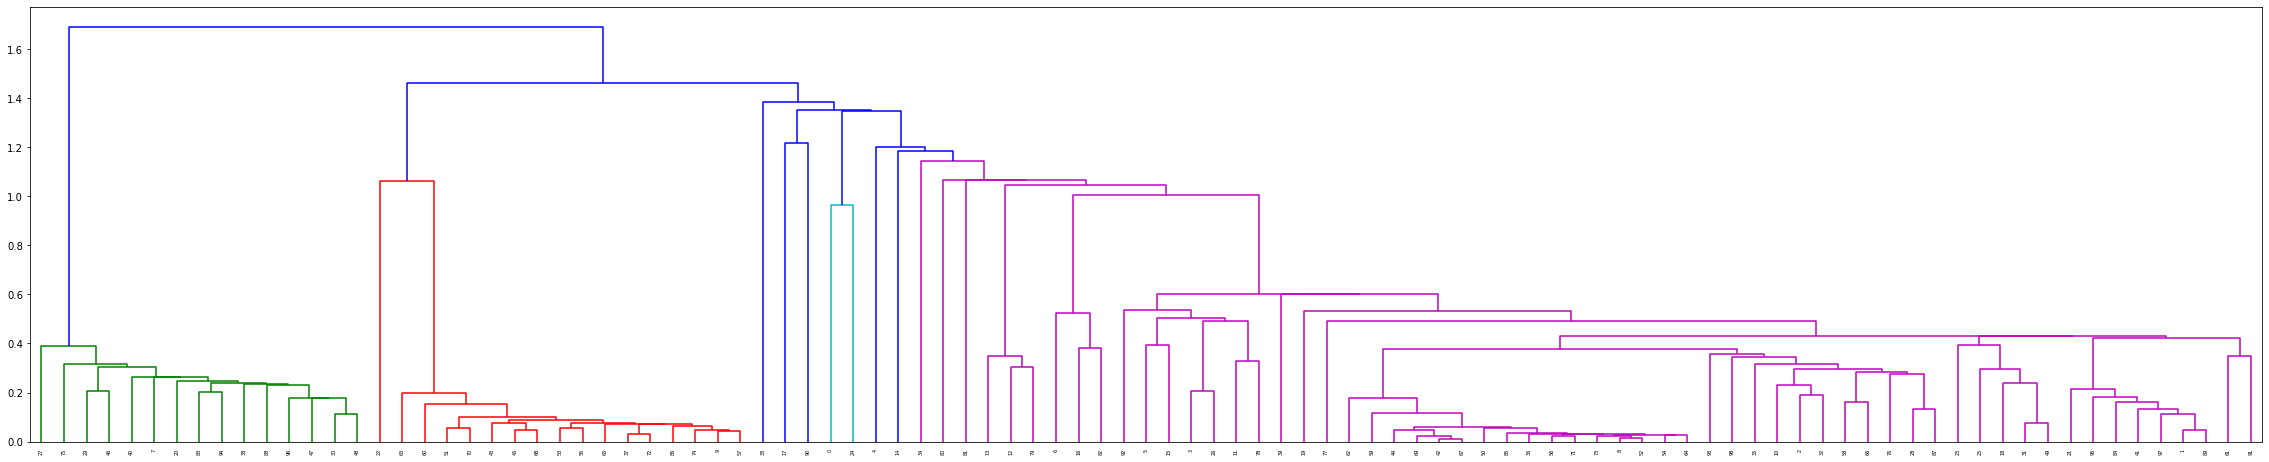

In [14]:
plt.figure(figsize=(40, 8))
dendrogram(rows)

df_s contains 99 peaks for 47 proteins!

Condensed distance matrix shape: (4851,)


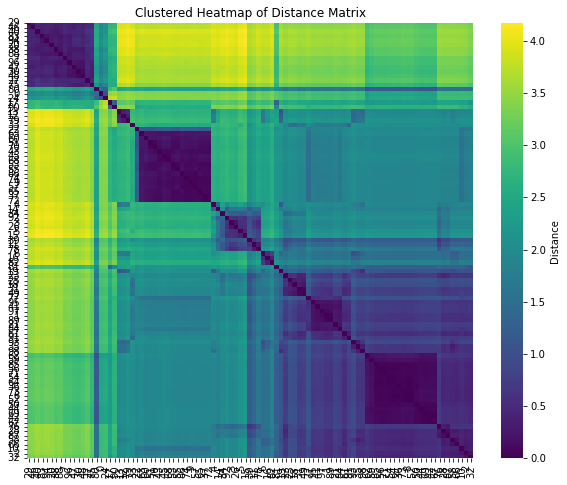

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute the condensed distance matrix
dist_matrix = pdist(df_s, metric='euclidean')  # Condensed vector
print("Condensed distance matrix shape:", dist_matrix.shape)

# Perform hierarchical clustering using the condensed distance matrix
linkage_result = linkage(dist_matrix, method='average')

# Create dendrogram to get ordering of rows/columns
dendro = dendrogram(linkage_result, no_plot=True)
ordered_indices = dendro['leaves']

# Convert condensed distance matrix to a square form
square_dist_matrix = squareform(dist_matrix)

# Reorder the square distance matrix based on the clustering
ordered_dist_matrix = square_dist_matrix[np.ix_(ordered_indices, ordered_indices)]

# Plot the clustered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_dist_matrix, 
            xticklabels=ordered_indices, 
            yticklabels=ordered_indices, 
            cmap='viridis', 
            annot=False,  # Set to False for larger datasets
            cbar_kws={'label': 'Distance'})
plt.title('Clustered Heatmap of Distance Matrix')
plt.show()


In [16]:
def allbyall_feat(prot_dict, npartitions, db):
    """
    Wrapper to compute all-by-all pairwise features.
    
    Parameters:
    - infile: Path to the input file containing elution profiles.
    - npartitions: Number of partitions for parallel processing.
    
    Returns:
    - pairwise_corr: DataFrame containing pairwise correlation results.
    """
    npartitions = max(1, int(npartitions))
    
    ppi_dict = db_to_dict(db)

    pairwise_corr = calc_feat_allbyall(prot_dict, npartitions=npartitions)

    pairwise_corr_db = add_ppi(pairwise_corr, ppi_dict)

    pairwise_corr_db['Label'] = pairwise_corr_db['db'].astype(int)

    performance_data = fit_logistic_model(pairwise_corr_db)

    return pairwise_corr_db, performance_data

In [17]:

from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve

prot_dict = io.read_txt(infile)

Number of analyzed genes in ..\test\test_frac.txt: 47


In [18]:
def generate_combinations(prot_dict):
    """
    Generate all unique protein pairs from the provided protein dictionary.
    
    Parameters:
    - prot_dict: Dictionary of proteins and their elution profiles.

    Returns:
    - DataFrame: All unique protein pairs.
    """
    pairs = pd.DataFrame(list(combinations(prot_dict.keys(), 2)), columns=['ProteinA', 'ProteinB'])
    return pairs


def gen_feat(row, prot_dict):
    """
    Compute Pearson correlation for a pair of proteins.
    
    Parameters:
    - row: DataFrame row containing 'ProteinA' and 'ProteinB'.
    - prot_dict: Dictionary with full elution profiles for all proteins.

    Returns:
    - Dict: Protein pair and their correlation.
    """
    prot_a = row['ProteinA']
    prot_b = row['ProteinB']

    if prot_a in prot_dict and prot_b in prot_dict:
        # Extract profiles for the two proteins
        elution_a = prot_dict[prot_a]
        elution_b = prot_dict[prot_b]
        
        # Calculate Pearson correlation
        corr_value = np.corrcoef(elution_a, elution_b)[0, 1]
        
        return {'ProteinA': prot_a, 'ProteinB': prot_b, 'Correlation': corr_value}
    else:
        return {'ProteinA': prot_a, 'ProteinB': prot_b, 'Correlation': np.nan}

def process_slice(df, prot_dict):
    """
    Process a slice of the DataFrame to compute pairwise features.
    
    Parameters:
    - df: DataFrame containing pairs of proteins (ProteinA, ProteinB).
    - prot_dict: Dictionary with full elution profiles for all proteins.

    Returns:
    - DataFrame: Pairwise correlation results for each pair in the slice.
    """
    return df.apply(lambda row: gen_feat(row, prot_dict), axis=1)

def calc_feat_allbyall(prot_dict, npartitions=4):
    """
    Calculate pairwise features across all protein combinations using partitioning.
    
    Parameters:
    - prot_dict: Dictionary of proteins and their elution profiles.
    - npartitions: Number of partitions for parallel processing.
    
    Returns:
    - DataFrame: Pairwise feature results for all combinations.
    """
    # Generate all pairwise combinations
    pairs = generate_combinations(prot_dict)
    
    # Partition the pairwise DataFrame
    ddf = dd.from_pandas(pairs, npartitions=npartitions)
    
    # Apply feature calculation across partitions
    results = ddf.map_partitions(lambda df: process_slice(df, prot_dict)).compute(scheduler='processes')
    
    return pd.DataFrame(results.tolist())


def db_to_dict(db):
    ppi_dict = {}
    for gene_names in db['subunits(Gene name)']:
        if pd.notna(gene_names):
            genes = [gene.upper() for gene in gene_names.split(';')]
            for gene_a in genes:
                if gene_a not in ppi_dict:
                    ppi_dict[gene_a] = set()
                for gene_b in genes:
                    if gene_a != gene_b:
                        ppi_dict[gene_a].add(gene_b)
    return ppi_dict

# Step 2: Check if a pair exists in CORUM
def add_ppi(pairs_df, ppi_dict):
    pairs_df['db'] = pairs_df.apply(
        lambda row: row['ProteinB'].upper() in ppi_dict.get(row['ProteinA'].upper(), set()),
        axis=1
    )
    return pairs_df

def fit_logistic_model(pairwise_corr_df):
    X = pairwise_corr_df[['Correlation']].values
    y = pairwise_corr_df['Label'].values

    model = LogisticRegression()
    model.fit(X, y)

    y_scores = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y, y_scores)
    pr_auc = auc(recall, precision)

    roc_df = pd.DataFrame({
        "fpr": fpr,
        "tpr": tpr
    })

    pr_df = pd.DataFrame({
        "precision": precision,
        "recall": recall
    })

    auc_df = pd.DataFrame({
        "curve": ["ROC", "PR"],
        "AUC": [roc_auc, pr_auc]
    })

    return roc_df, pr_df, auc_df

In [19]:
db = pd.read_csv("../coreComplexes.txt", sep="\t")

ppi_dict = db_to_dict(db)

pairwise_corr = calc_feat_allbyall(prot_dict, npartitions=8)

pairwise_corr_db = add_ppi(pairwise_corr, ppi_dict)

pairwise_corr_db['Label'] = pairwise_corr_db['db'].astype(int)

roc_df, pr_df, auc_df = fit_logistic_model(pairwise_corr_db)

In [20]:
auc_df

,curve,AUC
0,ROC,0.823842
1,PR,0.880605


In [21]:
pairwise_corr_db

,ProteinA,ProteinB,Correlation,db,Label
0,PSMD13,PSME2,-0.216686,True,1
1,PSMD13,PSMC3IP,-0.227912,False,0
2,PSMD13,PSMG3,-0.404602,False,0
3,PSMD13,PSMD1,0.967828,True,1
4,PSMD13,PSMB7,0.042789,True,1
...,...,...,...,...,...
1076,PSMD14,PSMD12,0.975819,True,1
1077,PSMD14,PSMD11,0.964469,True,1
1078,PSMD9,PSMD12,0.653034,True,1
1079,PSMD9,PSMD11,0.623115,True,1


In [22]:
pairwise_corr_db['db'].sum()/pairwise_corr_db.shape[0]

0.6188714153561518

In [23]:
from scipy.ndimage import uniform_filter1d

def clean_profile(chromatogram, impute_NA=True, smooth=True, smooth_width=4, noise_floor=0.001):
    """
    Clean an elution profile by imputing missing values, adding noise, and smoothing.
    
    Parameters:
    - chromatogram: np.ndarray, the elution profile (1D array).
    - impute_NA: bool, if True, impute missing/zero values using neighboring averages.
    - smooth: bool, if True, apply a moving average filter.
    - smooth_width: int, width of the moving average filter.
    - noise_floor: float, the maximum value for near-zero random noise.
    
    Returns:
    - cleaned: np.ndarray, the cleaned elution profile.
    """
    cleaned = np.copy(chromatogram)
    
    # Impute missing or zero values using mean of neighbors
    if impute_NA:
        for i in range(1, len(cleaned) - 1):
            if cleaned[i] == 0 or np.isnan(cleaned[i]):
                cleaned[i] = (cleaned[i - 1] + cleaned[i + 1]) / 2.0
    
    # Replace remaining missing or zero values with near-zero noise
    mask = (cleaned == 0) | np.isnan(cleaned)
    cleaned[mask] = np.random.uniform(0, noise_floor, size=mask.sum())
    
    # Apply moving average smoothing
    if smooth:
        padded = np.pad(cleaned, pad_width=smooth_width, mode='constant', constant_values=0)
        smoothed = uniform_filter1d(padded, size=smooth_width, mode='constant')
        cleaned = smoothed[smooth_width:-smooth_width]
    
    return cleaned

def clean_prot_dict(prot_dict, impute_NA=True, smooth=True, smooth_width=4, noise_floor=0.001):
    """
    Clean all elution profiles in a protein dictionary.
    
    Parameters:
    - prot_dict: dict, {protein: elution profile}.
    - impute_NA, smooth, smooth_width, noise_floor: cleaning parameters.
    
    Returns:
    - cleaned_dict: dict, {protein: cleaned elution profile}.
    """
    cleaned_dict = {}
    for protein, chromatogram in prot_dict.items():
        cleaned_dict[protein] = clean_profile(
            np.array(chromatogram),
            impute_NA=impute_NA,
            smooth=smooth,
            smooth_width=smooth_width,
            noise_floor=noise_floor
        )
    return cleaned_dict

No handles with labels found to put in legend.


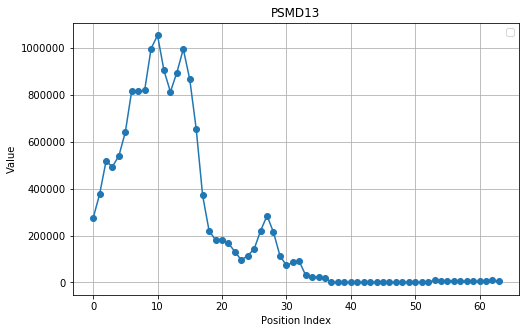

In [24]:
gene1 = next(iter(prot_dict))
dat_gene1 = prot_dict[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
clean_prot_dict = clean_prot_dict(prot_dict)

No handles with labels found to put in legend.


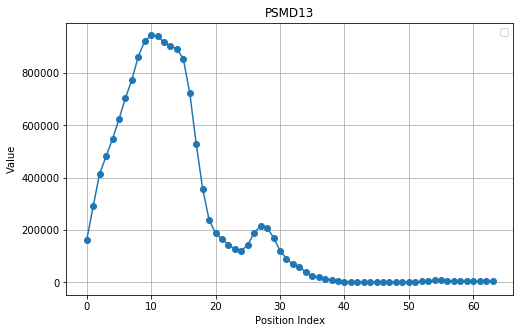

In [26]:
gene1 = next(iter(clean_prot_dict))
dat_gene1 = clean_prot_dict[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
list_names = ['marc_jacobs']

for name in list_names:
    print(name)

marc_jacobs


In [41]:
infile = "../test/test_frac.txt"

prot_dict = io.read_txt(infile)

def generate_combinations(prot_dict):
    """
    Generate all unique protein pairs from the provided protein dictionary.
    """
    return pd.DataFrame(list(combinations(prot_dict.keys(), 2)), columns=['ProteinA', 'ProteinB'])

pairs = generate_combinations(prot_dict=prot_dict)
pairs.head(10)

Number of analyzed genes in ../test/test_frac.txt: 47


,ProteinA,ProteinB
0,PSMD13,PSME2
1,PSMD13,PSMC3IP
2,PSMD13,PSMG3
3,PSMD13,PSMD1
4,PSMD13,PSMB7
5,PSMD13,PSMG2
6,PSMD13,PSMF1
7,PSMD13,GPSM1
8,PSMD13,PSMG4
9,PSMD13,PSMD5


In [60]:
keys

['PSMD13',
 'PSME2',
 'PSMC3IP',
 'PSMG3',
 'PSMD1',
 'PSMB7',
 'PSMG2',
 'PSMF1',
 'GPSM1',
 'PSMG4',
 'PSMD5',
 'PSMD6',
 'PSME4',
 'PSMD2',
 'PSME1',
 'PSMC6',
 'PSMC5',
 'PSMC1',
 'PSME3',
 'PSMA6',
 'PSMD4',
 'PSMD7',
 'PSMB2',
 'PSMB3',
 'PSMD8',
 'PSMC4',
 'PSMC2',
 'PSMB5',
 'PSMB6',
 'PSMB4',
 'PSMA5',
 'PSMB9',
 'PSMB8',
 'PSMA4',
 'PSMA3',
 'PSMA2',
 'PSMA1',
 'PSMB1',
 'PSMC3',
 'PSMG1',
 'PSMD10',
 'PSMD3',
 'PSMA7',
 'PSMD14',
 'PSMD9',
 'PSMD12',
 'PSMD11']

In [117]:
keys = list(prot_dict.keys())

proteinA = 'PSME1'
proteinB = 'PSMG3'


def calc_corr_test(proteinA, proteinB, W=10):
    a = np.array(prot_dict[proteinA])
    b = np.array(prot_dict[proteinB])

    am = uniform_filter(a.astype(float), W)
    bm = uniform_filter(b.astype(float), W)

    ac = a[W // 2 : -W // 2 + 1]
    bc = b[W // 2 : -W // 2 + 1]

    amc = am[W // 2 : -W // 2 + 1]
    bmc = bm[W // 2 : -W // 2 + 1]

    da = a[:, None] - amc
    db = b[:, None] - bmc

    # Get sliding mask of valid windows
    m, n = da.shape
    mask1 = np.arange(m)[:, None] >= np.arange(n)
    mask2 = np.arange(m)[:, None] < np.arange(n) + W
    mask = mask1 & mask2
    dam = da * mask
    dbm = db * mask

    ssAs = np.einsum("ij,ij->j", dam, dam)
    ssBs = np.einsum("ij,ij->j", dbm, dbm)
    D = np.einsum("ij,ij->j", dam, dbm)
    # add np.nan to reach 72
    cor = []
    cor.append(np.hstack((D / np.sqrt(ssAs * ssBs), np.zeros(9) + np.nan)))

    return ac, bc, amc, bmc, dam, dbm, cor



# Test the profiles
ac, bc, amc, bmc, dam, dbm, cor = calc_corr_test(proteinA, proteinB)

c:\Users\mumarc\AppData\Local\anaconda3\envs\pcprophet_env\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [129]:

W=10
cor_val = cor[0]
cor_val_clip = cor_val[W // 2 : -W // 2 + 1]

In [131]:
len(cor_val_clip)

55

No handles with labels found to put in legend.


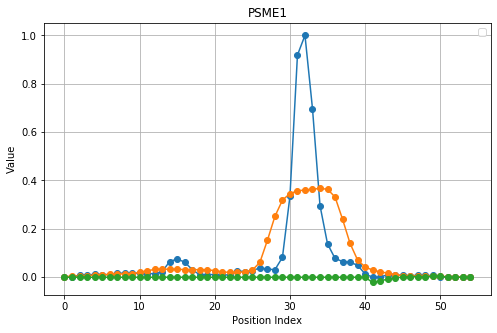

In [134]:
i=50

x_values = range(len(ac))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, ac/ac.max(), marker='o', linestyle='-')
plt.plot(x_values, amc/ac.max(), marker='o', linestyle='-')
plt.plot(x_values, dam[i]/ac.max(), marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{proteinA}')
plt.grid(True)
plt.legend()
plt.show()

No handles with labels found to put in legend.


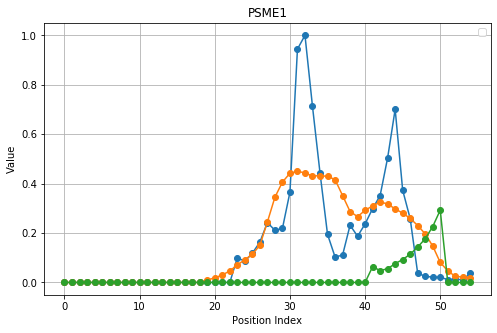

In [135]:
x_values = range(len(bc))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, bc/bc.max(), marker='o', linestyle='-')
plt.plot(x_values, bmc/bc.max(), marker='o', linestyle='-')
plt.plot(x_values, dbm[i]/bc.max(), marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{proteinA}')
plt.grid(True)
plt.legend()
plt.show()

No handles with labels found to put in legend.


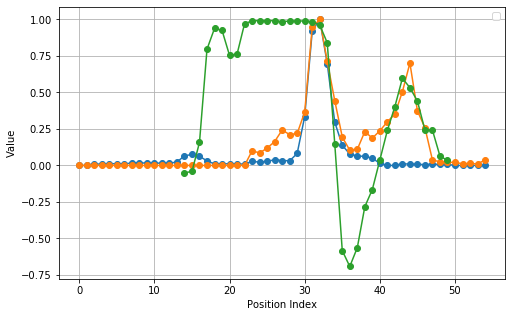

In [137]:
x_values = range(len(ac))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, ac/ac.max(), marker='o', linestyle='-')
plt.plot(x_values, bc/bc.max(), marker='o', linestyle='-')
plt.plot(x_values, cor_val_clip, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [142]:
def sliding_window_correlation(elution_a, elution_b, metric, window_size=6):
    """
    Calculate the sliding window correlations between two elution profiles and
    return a single value based on the specified metric (mean or max).
    
    Parameters:
    - elution_a, elution_b: np.ndarray, the two elution profiles.
    - metric: callable, the aggregation function to apply (e.g., mean, max).
    - window_size: int, the size of the sliding window.
    
    Returns:
    - result_corr: float, the aggregated Pearson correlation value.
    """
    # Ensure inputs are numpy arrays
    elution_a = np.array(elution_a)
    elution_b = np.array(elution_b)
    
    # Initialize correlations list and set the default result to -1
    correlations = []
    result_corr = -1

    # Slide the window across the profiles
    for start in range(len(elution_a) - window_size + 1):
        end = start + window_size
        window_a = elution_a[start:end]
        window_b = elution_b[start:end]

        # Check if there are enough valid (non-NA) values in the window
        valid_mask = (~np.isnan(window_a)) & (~np.isnan(window_b))
        if valid_mask.sum() < 2:  # Need at least two valid points for correlation
            continue

        # Calculate the Pearson correlation for the current window
        valid_a = window_a[valid_mask]
        valid_b = window_b[valid_mask]
        corr = np.corrcoef(valid_a, valid_b)[0, 1]

        if not np.isnan(corr):  # Ignore NaN values
            correlations.append(corr)
    
    # Handle cases where all correlations are NaN or no valid windows
    if correlations:
        result_corr = metric(correlations)
    
    return result_corr, correlations

In [146]:
a = np.array(prot_dict[proteinA])
b = np.array(prot_dict[proteinB])

max_corr, corr = sliding_window_correlation(elution_a=a, elution_b=b, metric=max, window_size=10)

c:\Users\mumarc\AppData\Local\anaconda3\envs\pcprophet_env\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\mumarc\AppData\Local\anaconda3\envs\pcprophet_env\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [147]:
len(corr)

36